# Two Translating Plates at 20°

In [1]:
using Pkg
Pkg.activate("/Users/jeff/PotentialFlow")

"/Users/jeff/PotentialFlow"

In [2]:
using PotentialFlow

In [3]:
using LinearAlgebra

## Set up

At the beginning of every time-step, we first determine the bound vortex sheet strength required to satisfy the no-flow-through condition, then velocity of all vortex elements:

In [5]:
function compute_ẋ!(ẋ, x, t)
    plate1, plate2, ambient_sys = x
    motion1, motion2, ambient_vel = ẋ
    
    Plates.enforce_no_flow_through!(plate1, motion1, plate2, motion2, ambient_sys, t)
    
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new segments of the vortex sheet from the edges of the plate.
Since we are dealing with a low angle of attack case, only the trailing edge will be forced to satisfy the Kutta condition.
Vorticity released from the leading edge will instead follow the leading edge suction parameter (LESP) criteria described in [Ramesh et al. 2014](https://doi.org/10.1017/jfm.2014.297).

In [83]:

function shed_new_vorticity!(sheet1₊, sheet1₋, plate1, motion1, sheet2₊, sheet2₋, plate2, motion2, t, lesp = 0.0, tesp = 0.0)
    z1₊ = (sheet1₊.blobs[end].z + 2plate1.zs[end])/3
    z1₋ = (sheet1₋.blobs[end].z + 2plate1.zs[1])/3
    
    z2₊ = (sheet2₊.blobs[end].z + 2plate2.zs[end])/3
    z2₋ = (sheet2₋.blobs[end].z + 2plate2.zs[1])/3
    
    segment1₊ = Vortex.Blob.([sheet1₊.blobs[end].z, z1₊], [0.5, 0.5], δ)
    segment1₋ = Vortex.Blob.([sheet1₋.blobs[end].z, z1₋], [0.5, 0.5], δ)
    
    segment2₊ = Vortex.Blob.([sheet2₊.blobs[end].z, z2₊], [0.5, 0.5], δ)
    segment2₋ = Vortex.Blob.([sheet2₋.blobs[end].z, z2₋], [0.5, 0.5], δ)
    
    global Γ1₊ = 0.0
    global Γ1₋ = 0.0
    global Γ2₊ = 0.0
    global Γ2₋ = 0.0
    err = 1
    
    #plate1tmp = deepcopy(plate1)
    #plate2tmp = deepcopy(plate2)
    
    while err > 1e-10
    
        sheet1tmp₊ = deepcopy(sheet1₊)
        sheet1tmp₋ = deepcopy(sheet1₋)
        sheet2tmp₊ = deepcopy(sheet2₊)
        sheet2tmp₋ = deepcopy(sheet2₋)
        
        Vortex.Sheets.append_segment!(sheet1tmp₊, z1₊, Γ1₊)
        Vortex.Sheets.append_segment!(sheet1tmp₋, z1₋, Γ1₋)
        Vortex.Sheets.append_segment!(sheet2tmp₊, z2₊, Γ2₊)
        Vortex.Sheets.append_segment!(sheet2tmp₋, z2₋, Γ2₋)

        Plates.enforce_no_flow_through!(plate1, motion1, plate2, motion2, (sheet1tmp₊, sheet1tmp₋, sheet2tmp₊, sheet2tmp₋), t)
        #Plates.enforce_no_flow_through!(plate1, motion1, (plate2tmp,sheet2tmp₊,sheet2tmp₋), 0)
        #Plates.enforce_no_flow_through!(plate2, motion2, (plate1tmp,sheet1tmp₊,sheet1tmp₋), 0)
        
        ΔΓ1₊, ΔΓ1₋, _, _ = Plates.vorticity_flux(plate1, segment1₊, segment1₋, t, lesp, tesp);
        ΔΓ2₊, ΔΓ2₋, _, _ = Plates.vorticity_flux(plate2, segment2₊, segment2₋, t, lesp, tesp);
            
        Γ1₊ += ΔΓ1₊
        Γ1₋ += ΔΓ1₋
        Γ2₊ += ΔΓ2₊
        Γ2₋ += ΔΓ2₋
        
        
            
        #Plates.enforce_no_flow_through!(plate1tmp, motion1, (sheet1tmp₊,sheet1tmp₋), 0)
        #Plates.enforce_no_flow_through!(plate2tmp, motion2, (sheet2tmp₊,sheet2tmp₋), 0)
        
        err = sqrt(ΔΓ1₊^2 + ΔΓ1₋^2 + ΔΓ2₊^2 + ΔΓ2₋^2)
    
    end
    
    Vortex.Sheets.append_segment!(sheet1₊, z1₊, Γ1₊)
    Vortex.Sheets.append_segment!(sheet1₋, z1₋, Γ1₋)
    Vortex.Sheets.append_segment!(sheet2₊, z2₊, Γ2₊)
    Vortex.Sheets.append_segment!(sheet2₋, z2₋, Γ2₋)
    
    #sheet1₊ = deepcopy(sheet1tmp₊)
    #sheet1₋ = deepcopy(sheet1tmp₋)
    #sheet2₊ = deepcopy(sheet2tmp₊)
    #sheet2₋ = deepcopy(sheet2tmp₋)
    
end

shed_new_vorticity! (generic function with 3 methods)

In [84]:
function Plates.enforce_no_flow_through!(p1::Plate,ṗ1,p2::Plate,ṗ2,elements,t)
    err1 = err2 = 1
    iter = 0
    while max(err1,err2) > 1e-10
        C1_old = copy(p1.C)
        C2_old = copy(p2.C)
        Plates.enforce_no_flow_through!(p1, ṗ1, (p2,elements), t)
        Plates.enforce_no_flow_through!(p2, ṗ2, (p1,elements), t)
        err1 = norm(p1.C-C1_old)
        err2 = norm(p2.C-C2_old)
        iter += 1
    end
    nothing
end

function Plates.influence_on_plate!(∂A1::Vector{ComplexF64}, ∂A2::Vector{ComplexF64}, plate1::Plate, plate2::Plate, v, t)
    err1 = err2 = 1
    iter = 0
    ∂A1old = zeros(ComplexF64,plate1.N)
    ∂A2old = zeros(ComplexF64,plate2.N)
    ∂A1 = copy(∂A1old)
    ∂A2 = copy(∂A2old)
    p1tmp = deepcopy(p1)
    p2tmp = deepcopy(p2)
    p1tmp.C .= ∂A1
    p2tmp.C .= ∂A2 
    while max(err1,err2) > 1e-10
        
        Plates.influence_on_plate!(∂A1, p1, (v,p2tmp), t)
        Plates.influence_on_plate!(∂A2, p2, (v,p1tmp), t)
            
        p1tmp.C .= ∂A1
        p2tmp.C .= ∂A2     
        err1 = norm(∂A1-∂A1old)
        err2 = norm(∂A2-∂A2old)
        ∂A1old = copy(∂A1)
        ∂A2old = copy(∂A2)
        iter += 1
    end
    println("number of iterations = ",iter)
    nothing
end



### Discretize the plate and sheets

We are simulating a flat plate with zero thickness impulsively translating horizontally at a fixed velocity and angle of attack

In [164]:
L = 1.0   # chord length
N = 128   # number of plate control points (distributed along a extrema Chebyshev grid)

ċ = -L  # translation velocity
α = -π/2   # angle of attack

Δt = 1e-2; # time step

plate1 = Plate(N, L, zero(ComplexF64), α)
motion1 = Plates.RigidBodyMotion(ċ, 0.0);

plate2 = Plate(N, L, 1.2+im*0, α)
motion2 = Plates.RigidBodyMotion(ċ, 0.0);

We place the initial segments of the vortex sheets perpendicularly off each edge of the plate.
The sheets themselves are represented as discrete vortex blobs, all with the same blob radius `δ`.
Both segments initially have unit circulation.

In [165]:
Δz₀ = im*Δt*exp(im*α)
z1₋, z1₊ = plate1.zs[[1,N]]
z2₋, z2₊ = plate2.zs[[1,N]]


δ = 0.1

segment1₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₊, [0.0, 1.0], δ)
segment1₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₋, [0.0, 1.0], δ)

segment2₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₊, [0.0, 1.0], δ)
segment2₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₋, [0.0, 1.0], δ)

sheet1₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₊, [0.0, 0.0], δ)
sheet1₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₋, [0.0, 0.0], δ)
sheet2₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₊, [0.0, 0.0], δ)
sheet2₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₋, [0.0, 0.0], δ) 

Vortex Sheet: L ≈ 0.01, Γ = 0.0, δ = 0.1

We then adjust the circulation in the vortex sheet segments to satisfy the leading and trailing edge suction parameters.
Since we want the Kutta condition to be satisfied at the trailing edge, we set the critical trailing edge suction parameter to zero.

In [166]:
lesp = 0.0
tesp = 0.0


global Γ1₊ = 0
global Γ1₋ = 0
global Γ2₊ = 0
global Γ2₋ = 0
err = 1.0
#plate1tmp = deepcopy(plate1)
#plate2tmp = deepcopy(plate2)
while err > 1e-10
    
        Plates.enforce_no_flow_through!(plate1, motion1, plate2, motion2, (sheet1₊, sheet1₋, sheet2₊, sheet2₋), 0)        

        #Plates.enforce_no_flow_through!(plate1, motion1, (plate2tmp,sheet2₊,sheet2₋), 0)
        #Plates.enforce_no_flow_through!(plate2, motion2, (plate1tmp,sheet1₊,sheet1₋), 0)
            
        ΔΓ1₊, ΔΓ1₋, _, _ = Plates.vorticity_flux(plate1, segment1₊, segment1₋, 0, lesp, tesp);
        ΔΓ2₊, ΔΓ2₋, _, _ = Plates.vorticity_flux(plate2, segment2₊, segment2₋, 0, lesp, tesp);
    
        #println(ΔΓ1₊,"    ",ΔΓ2₊,"    ",ΔΓ1₋,"    ",ΔΓ2₋)
        Γ1₊ += ΔΓ1₊
        Γ1₋ += ΔΓ1₋
        Γ2₊ += ΔΓ2₊
        Γ2₋ += ΔΓ2₋
    
        sheet1₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₊, [0.0, Γ1₊], δ)
        sheet1₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z1₋, [0.0, Γ1₋], δ)
        sheet2₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₊, [0.0, Γ2₊], δ)
        sheet2₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ .+ z2₋, [0.0, Γ2₋], δ)
    
        #Plates.enforce_no_flow_through!(plate1tmp, motion1, (sheet1₊,sheet1₋), 0)
        #Plates.enforce_no_flow_through!(plate2tmp, motion2, (sheet2₊,sheet2₋), 0)
    
        err = sqrt(ΔΓ1₊^2 + ΔΓ1₋^2 + ΔΓ2₊^2 + ΔΓ2₋^2)
end
    

In [167]:
using Plots
clibrary(:colorbrewer)

:colorbrewer

We organize the flow elements into the plate and ambient elements.

In [168]:
ambient_sys = (sheet1₊, sheet1₋,sheet2₊, sheet2₋)
sys = (plate1, plate2, ambient_sys)
ẋs = (motion1, motion2, allocate_velocity(ambient_sys));

## Time-Marching

We use forward Euler to evolve the system and apply filtering on both the leading and trailing edge vortex sheets to surpress small-scale instabilities.

In [178]:
tf = 0.1
T = 0:Δt:tf

for t in T
    TimeMarching.forward_euler!(sys, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    # Redistribute the points along the free vortex sheet to be at least 2UΔt
    # apart from each other.  At the same time, we filter out any length scales
    # along the sheet shorter than 6UΔt
    for s in 1:4
        Sheets.arclength(sys[3][s]) ≥ 3Δt && Sheets.filter!(sys[3][s], 2Δt, 6Δt)
    end
    
    #sheet1₊, sheet1₋, plate1, motion1, sheet2₊, sheet2₋, plate2, motion2
    
    shed_new_vorticity!(sys[3][1], sys[3][2], sys[1], ẋs[1], sys[3][3], sys[3][4], sys[2], ẋs[2], t + Δt, lesp, tesp)
end

## Plotting

Most flow elements in the library has [plot recipes](https://github.com/JuliaPlots/RecipesBase.jl) defined for them.
So once [`Plots.jl`](https://github.com/JuliaPlots/Plots.jl) is installed along with the appropriate backend, we can directly call `plot` on the potential flow elements.

In [176]:
using Plots
clibrary(:colorbrewer)

:colorbrewer

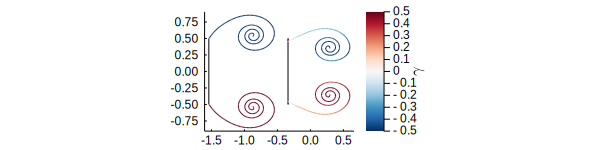

In [179]:
plot(sys, ratio = 1, color = :RdBu_r, clims = (-0.5, 0.5), 
     legend = :none, colorbar = :right, colorbar_title = "\$\\gamma\$", 
     size = (600, 150), grid = false)

In [84]:
sys

(Plate: N = 128, L = 1.0, c = 1.0100000000000007 + 0.0im, α = -20.0ᵒ
       LESP = NaN, TESP = NaN, Plate: N = 128, L = 1.0, c = 2.209999999999996 + 0.0im, α = -20.0ᵒ
       LESP = NaN, TESP = NaN, (Vortex Sheet: L ≈ NaN, Γ = -0.124, δ = 0.01, Vortex Sheet: L ≈ NaN, Γ = 0.144, δ = 0.01, Vortex Sheet: L ≈ NaN, Γ = -0.125, δ = 0.01, Vortex Sheet: L ≈ NaN, Γ = 0.144, δ = 0.01))